# Libraries

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import wkt

import geopandas as gpd
import pandas as pd
from shapely import wkt
from shapely.geometry import Polygon

import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import logging
import datetime

import itertools
from multiprocessing import Pool, cpu_count
import multiprocessing

In [2]:
##Logger
logging.root.handlers.clear()
logging.root.handlers

# timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# log_filename = f"logs/CuscoEdgesWaze1400_{timestamp}.log"

# logging.basicConfig(
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S',
# )

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')

# fileHandler = logging.FileHandler(log_filename)
# fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(logFormatter)
logger.addHandler(streamHandler)
##Logger

# Functions

In [498]:
H3_RESOLUTION = 8

def geo_to_h3 (row):
    return h3.geo_to_h3(row.y, row.x, resolution=H3_RESOLUTION)

from shapely.geometry import Polygon
def add_geometry(row):
    points = h3.h3_to_geo_boundary(row['h3_cell'], True)
    return Polygon(points)

# Mapa Lima-Callao

In [499]:
mapaLimaCallao = pd.read_csv('../SimBig22/rutas/MapaLimaCallao.csv')
mapaLimaCallao['geometry'] = mapaLimaCallao['geometry'].apply(wkt.loads)
mapaLimaCallao = gpd.GeoDataFrame(mapaLimaCallao, crs='epsg:4326')
mapaLimaCallao['distrito2'] = mapaLimaCallao.apply(lambda x: x['distrito'].replace(' ','_'), axis=1)
mapaLimaCallao.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry,LimaCallao,distrito2
0,7,CALLAO,701,CALLAO,70105,LA PUNTA,LA PUNTA,1,1,INEI,"POLYGON ((-77.15884 -12.06645, -77.15874 -12.0...",True,LA_PUNTA
1,7,CALLAO,701,CALLAO,70104,LA PERLA,LA PERLA,1,1,INEI,"POLYGON ((-77.10444 -12.07020, -77.10486 -12.0...",True,LA_PERLA
2,7,CALLAO,701,CALLAO,70102,BELLAVISTA,BELLAVISTA,1,1,INEI,"POLYGON ((-77.10086 -12.06307, -77.10317 -12.0...",True,BELLAVISTA
3,7,CALLAO,701,CALLAO,70103,CARMEN DE LA LEGUA REYNOSO,CARMEN DE LA LEGUA REYNOSO,1,1,INEI,"POLYGON ((-77.08317 -12.03925, -77.08263 -12.0...",True,CARMEN_DE_LA_LEGUA_REYNOSO
4,7,CALLAO,701,CALLAO,70101,CALLAO,CALLAO,1,1,INEI,"POLYGON ((-77.11219 -11.97352, -77.11203 -11.9...",True,CALLAO


# Nodes & Edges

In [4]:
lima_nodes = pd.read_csv("data/GrafoLima_nodes.csv", index_col=[0])
lima_nodes['geometry'] = lima_nodes['geometry'].apply(wkt.loads)
lima_nodes = gpd.GeoDataFrame(lima_nodes, crs='epsg:4326')

lima_edges = pd.read_csv("data/GrafoLima_edgeswaze.csv", index_col=[0,1,2])
lima_edges['geometry'] = lima_edges['geometry'].apply(wkt.loads)
lima_edges = gpd.GeoDataFrame(lima_edges, crs='epsg:4326')

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,7,13,14,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [500]:
%%time
lima_nodes['h3_cell'] = lima_nodes.apply(geo_to_h3, axis=1)

CPU times: user 17.4 s, sys: 151 ms, total: 17.5 s
Wall time: 17.5 s


In [501]:
lima_nodes.head()

,y,x,ref,highway,street_count,geometry,h3_cell,h3_geometry
osmid,,,,,,,,
258066779,-12.371360,-76.784678,45A,motorway_junction,3,POINT (-76.78468 -12.37136),888e620059fffff,NaN
258066780,-12.376318,-76.779559,NaN,NaN,3,POINT (-76.77956 -12.37632),888e62005bfffff,NaN
258066781,-12.384553,-76.771046,NaN,NaN,3,POINT (-76.77105 -12.38455),888e6202a9fffff,NaN
258066783,-12.385783,-76.769768,NaN,NaN,3,POINT (-76.76977 -12.38578),888e6202a9fffff,NaN
258067237,-12.304254,-76.840727,NaN,NaN,3,POINT (-76.84073 -12.30425),888e620349fffff,NaN


In [502]:
%%time
lima_nodes_h3 = lima_nodes.dissolve(by='h3_cell')

CPU times: user 1.95 s, sys: 40 ms, total: 1.99 s
Wall time: 1.99 s


In [503]:
%%time
# lima_nodes_h3
lima_nodes_h3.reset_index(inplace=True)
lima_nodes_h3['h3_geometry'] = (lima_nodes_h3.apply(add_geometry,axis=1))
lima_nodes_h3.set_index('h3_cell', inplace=True)

CPU times: user 5.09 s, sys: 23.8 ms, total: 5.11 s
Wall time: 5.11 s


In [504]:
lima_nodes_h3.set_geometry('h3_geometry', inplace=True)

CPU times: user 1.18 s, sys: 217 ms, total: 1.4 s
Wall time: 990 ms


<AxesSubplot:>

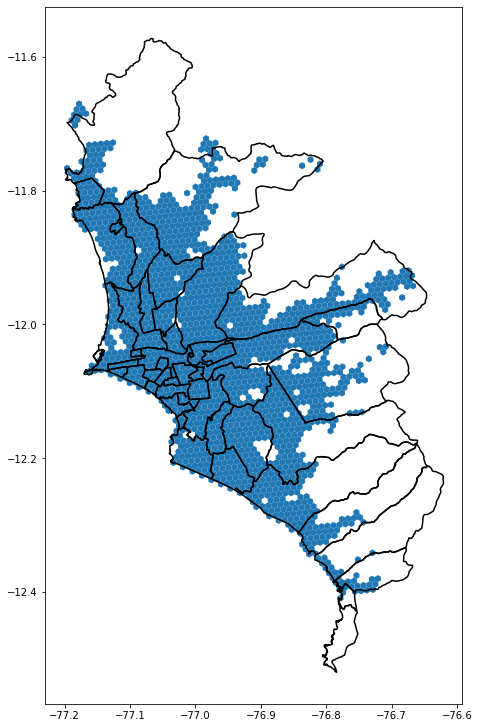

In [505]:
%%time
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))

mapaLimaCallao.boundary.plot(ax=ax, color='black', )

lima_nodes_h3.plot(ax=ax)

In [506]:
lima_nodes_h3.head()

,geometry,y,x,ref,highway,street_count,h3_geometry
h3_cell,,,,,,,
888e620049fffff,"MULTIPOINT (-76.80960 -12.35459, -76.80934 -12...",-12.355146,-76.804209,NaN,NaN,3,"POLYGON ((-76.80695 -12.35199, -76.81127 -12.3..."
888e62004bfffff,"MULTIPOINT (-76.79953 -12.36059, -76.79881 -12...",-12.363812,-76.797757,NaN,NaN,3,"POLYGON ((-76.80162 -12.35931, -76.80594 -12.3..."
888e620051fffff,"MULTIPOINT (-76.79022 -12.37563, -76.79005 -12...",-12.375176,-76.788227,NaN,NaN,3,"POLYGON ((-76.79095 -12.37397, -76.79526 -12.3..."
888e620053fffff,"MULTIPOINT (-76.78906 -12.38464, -76.78904 -12...",-12.389264,-76.781312,NaN,NaN,3,"POLYGON ((-76.78561 -12.38129, -76.78993 -12.3..."
888e620059fffff,"MULTIPOINT (-76.79106 -12.37120, -76.79093 -12...",-12.371360,-76.784678,45A,motorway_junction,3,"POLYGON ((-76.78714 -12.36573, -76.79146 -12.3..."


In [513]:
lima_nodes_h3['h3_geometry'] = lima_nodes_h3['h3_geometry'].to_crs(crs='epsg:4326')

In [514]:
lima_nodes_h3['h3_centroid'] = lima_nodes_h3['h3_geometry'].centroid

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [517]:
lima_nodes_h3['geometry_origen'] = lima_nodes_h3['geometry']

In [521]:
lima_nodes_h3['geometry'] = lima_nodes_h3['h3_geometry'].centroid
lima_nodes_h3.set_geometry('geometry', inplace=True)

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


CPU times: user 827 ms, sys: 136 ms, total: 963 ms
Wall time: 709 ms


<AxesSubplot:>

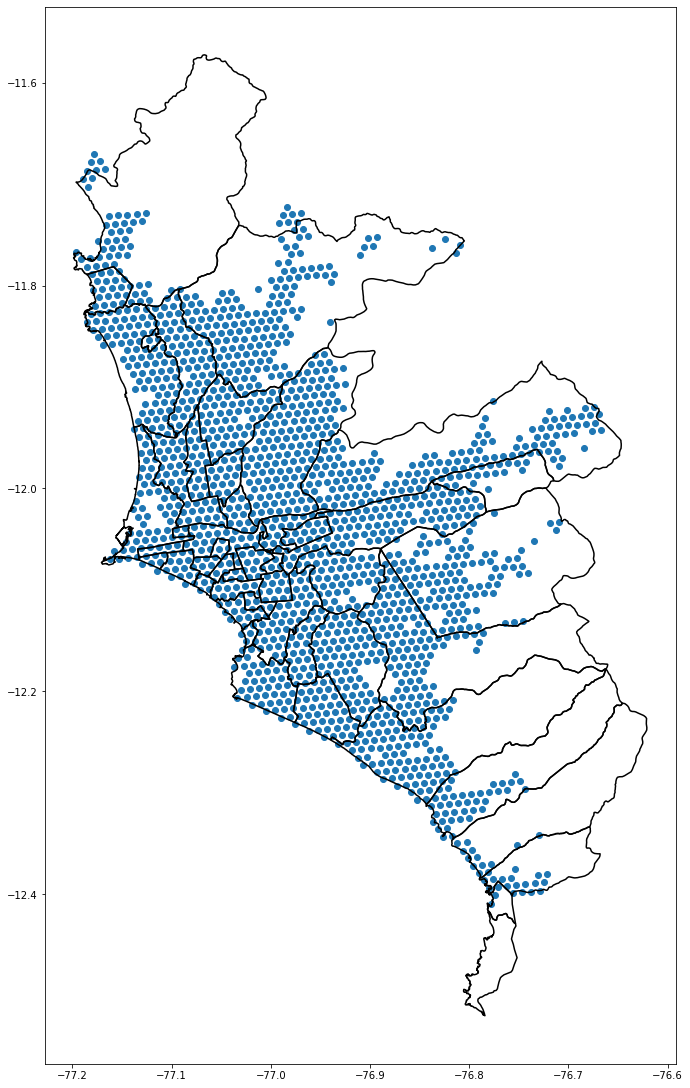

In [525]:
%%time
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,15))

mapaLimaCallao.boundary.plot(ax=ax, color='black', )

lima_nodes_h3.plot(ax=ax)

In [529]:
%%time
logger.info("Proceso SNAP Inicio")
limanodesh3_snap_limanodes = gn.pandana_snap_points(lima_nodes_h3, lima_nodes)
logger.info("Proceso SNAP Fin")

2024-02-28 12:53:59,806 :: INFO :: root :: 29410 :: Proceso SNAP Inicio
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' s

CPU times: user 6h 39min 25s, sys: 5min 22s, total: 6h 44min 48s
Wall time: 6h 44min 44s


In [534]:
limanodesh3_snap_limanodes.rename(columns={'NN':'glima_osmid', 'NN_dist':'glima_dist' }, inplace=True)
# limanodesh3_snap_limanodes.head()

In [533]:
limanodesh3_snap_limanodes.to_csv("data/LimaH3R8SnapLimaNodes.csv", sep=";")

In [535]:
limanodesh3_snap_limanodes.head()

,geometry,ref,highway,street_count,h3_geometry,h3_centroid,geometry_origen,glima_osmid,glima_dist
h3_cell,,,,,,,,,
888e620049fffff,POINT (-76.80645 -12.35718),NaN,NaN,3,"POLYGON ((-76.80695 -12.35199, -76.81127 -12.3...",POINT (-76.80645 -12.35718),"MULTIPOINT (-76.80960 -12.35459, -76.80934 -12...",1826469795,0.001340
888e62004bfffff,POINT (-76.80111 -12.36450),NaN,NaN,3,"POLYGON ((-76.80162 -12.35931, -76.80594 -12.3...",POINT (-76.80111 -12.36450),"MULTIPOINT (-76.79953 -12.36059, -76.79881 -12...",1826469868,0.003403
888e620051fffff,POINT (-76.79044 -12.37915),NaN,NaN,3,"POLYGON ((-76.79095 -12.37397, -76.79526 -12.3...",POINT (-76.79044 -12.37915),"MULTIPOINT (-76.79022 -12.37563, -76.79005 -12...",1817713787,0.001273
888e620053fffff,POINT (-76.78510 -12.38648),NaN,NaN,3,"POLYGON ((-76.78561 -12.38129, -76.78993 -12.3...",POINT (-76.78510 -12.38648),"MULTIPOINT (-76.78906 -12.38464, -76.78904 -12...",4971035699,0.002200
888e620059fffff,POINT (-76.78663 -12.37091),45A,motorway_junction,3,"POLYGON ((-76.78714 -12.36573, -76.79146 -12.3...",POINT (-76.78663 -12.37091),"MULTIPOINT (-76.79106 -12.37120, -76.79093 -12...",1832653117,0.000538


# Grafo 

In [405]:
%%time
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(lima_nodes, lima_edges, graph_attrs)
print(nx.info(G))

H = G.to_undirected() #H es el Grafo no dirigido

print(nx.info(H))

Name: 
Type: MultiDiGraph
Number of nodes: 148111
Number of edges: 395620
Average in degree:   2.6711
Average out degree:   2.6711
Name: 
Type: MultiGraph
Number of nodes: 148111
Number of edges: 222783
Average degree:   3.0083
CPU times: user 2min 38s, sys: 2.64 s, total: 2min 41s
Wall time: 2min 41s


# Amenities

In [6]:
%%time
place_name = "Lima Metropolitana"
# graph = ox.graph_from_place(place_name, which_result=3, network_type='drive')
amenitiesLima = ox.geometries_from_place(place_name,tags={'amenity':True} )

from shapely.geometry import Point
amenitiesLima['isPoint'] = amenitiesLima.apply(lambda x: type(x.geometry) is Point , axis=1)
amenitiesLima.rename(columns={'geometry':'geometry_polygon'}, inplace=True)
amenitiesLima['geometry'] = amenitiesLima.apply(lambda x: x['geometry_polygon'].centroid, axis=1)
amenitiesLima.set_geometry('geometry')
amenitiesLima.set_index('osmid', inplace=True)
amenitiesLima.head(2)

CPU times: user 46.5 s, sys: 2.08 s, total: 48.5 s
Wall time: 48.5 s


,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,bicycle_rental,trolleybus,fuel:octane_87,internet,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
3259019072,node/3259019072,node,police,POINT (-76.82449 -12.33707),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.82449 -12.33707)
3759247695,node/3759247695,node,bank,POINT (-76.90608 -12.21089),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90608 -12.21089)
3759586688,node/3759586688,node,bank,POINT (-76.91030 -12.23102),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.91030 -12.23102)
4235492500,node/4235492500,node,school,POINT (-76.78649 -12.49113),NaN,NaN,NaN,NaN,NaN,Entrada A Pucusana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.78649 -12.49113)
4235507693,node/4235507693,node,school,POINT (-76.79644 -12.48408),NaN,NaN,NaN,NaN,NaN,Callao,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.79644 -12.48408)


# Find nearest amenity to graph with h3

In [484]:
# cols = ['bank', 'school', 'police', 'hospital', 'university', 'courthouse']
var_amenity = 'school'

logger.info(f"Starting process for amenity {var_amenity} ")

cols = [var_amenity]
amenities = amenitiesLima.query("amenity in @cols").copy()
amenities.dropna(how='all', axis=1, inplace=True)
print(amenities.shape)
amenities['amenity'].unique()
amenities['x'] = amenities['geometry'].x
amenities['y'] = amenities['geometry'].y
amenities['h3_cell'] = amenities.apply(geo_to_h3, axis=1)

# amenities.head()
logger.info(f"Transforming amenities to h3 ")

amenities_h3 = amenities.dissolve(by='h3_cell')
amenities_h3.reset_index(inplace=True)
amenities_h3['h3_geometry'] = (amenities_h3.apply(add_geometry,axis=1))
amenities_h3.set_index('h3_cell', inplace=True)
amenities_h3.set_geometry('h3_geometry', inplace=True)
print(amenities_h3.shape)

2024-02-25 23:18:58,053 :: INFO :: root :: 29410 :: Starting process for amenity school 


(6010, 83)


2024-02-25 23:18:59,811 :: INFO :: root :: 29410 :: Transforming amenities to h3 


(243, 86)


In [485]:
amenities_h3.head()

,geometry,unique_id,element_type,amenity,geometry_polygon,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,preschool,wall,source_ref,building:material,addr:place,building:use,isPoint,x,y,h3_geometry
h3_cell,,,,,,,,,,,,,,,,,,,,,
878e62004ffffff,POINT (-76.80190 -12.35703),node/5593357478,node,school,POINT (-76.80190 -12.35703),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-76.801897,-12.357027,"POLYGON ((-76.81610 -12.35290, -76.82423 -12.3..."
878e62005ffffff,"MULTIPOINT (-76.79440 -12.36740, -76.79428 -12...",node/4834711721,node,school,POINT (-76.79428 -12.36747),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-76.794283,-12.367471,"POLYGON ((-76.79628 -12.36664, -76.80441 -12.3..."
878e62022ffffff,POINT (-76.80860 -12.35160),node/5593357481,node,school,POINT (-76.80860 -12.35160),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-76.808597,-12.351600,"POLYGON ((-76.81382 -12.32909, -76.82194 -12.3..."
878e62023ffffff,"MULTIPOINT (-76.79850 -12.36082, -76.79560 -12...",node/5593356806,node,school,POINT (-76.79560 -12.36517),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,-76.795600,-12.365170,"POLYGON ((-76.79400 -12.34284, -76.80213 -12.3..."
878e62024ffffff,POINT (-76.78565 -12.30486),way/684690218,way,school,"POLYGON ((-76.78511 -12.30423, -76.78534 -12.3...",NaN,NaN,Pampa Pacta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-76.785652,-12.304855,"POLYGON ((-76.78944 -12.29523, -76.79757 -12.3..."


In [486]:
def find_nearest_routes(graph, source_nodes, target_nodes, weight=None):
    nearest_routes = {}
    for source_node in source_nodes:
        nearest_routes[source_node] = {}
        for target_node in target_nodes:
            try:
                if weight is None:
                    shortest_path = nx.shortest_path(graph, source=source_node, target=target_node)
                else:
                    shortest_path = nx.shortest_path(graph, source=source_node, 
                                                     target=target_node, weight=weight)
                shortest_distance = nx.shortest_path_length(graph, source=source_node, 
                                                            target=target_node, weight=weight)
#                 nearest_routes[source_node][target_node] = {'path': shortest_path, 'distance': shortest_distance}
                nearest_routes[source_node][target_node] = shortest_distance

                # Si se encontró una ruta válida, pasar al siguiente par de nodos de destino
                break
            except nx.NetworkXNoPath:
                nearest_routes[source_node][target_node] = None
    return nearest_routes

def find_nearest_routes_h3 (graph, source_h3, target_h3, weight=None):
    source_nodes = lima_nodes.query("h3_cell == @source_h3")
    target_nodes = lima_nodes.query("h3_cell == @target_h3")
    nearest_routes = find_nearest_routes(graph, 
                                         source_nodes.index, 
                                         target_nodes.index, 
                                         weight=weight
                                        )  
    df = pd.DataFrame.from_dict(nearest_routes, orient='index')
    return np.nanmean(df)


In [487]:
nodes_source = list(set(lima_nodes_h3.index))
print(len(nodes_source))

nodes_target = lima_nodes_h3.index.intersection(amenities_h3.index)
print(len(nodes_target))

339
241


In [488]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))
len(nodes_sourcecrosstarget)

81699

In [489]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,878e6299affffff,878e62004ffffff
1,878e6299affffff,878e62005ffffff
2,878e6299affffff,878e62022ffffff


In [490]:
nodes_sourcecrosstarget_df.shape[0] , nodes_sourcecrosstarget_df.shape[0]/40

(81699, 2042.475)

In [491]:
def shortest_path_transporte(graph, node_source, node_target):
    try:
        resdict = {}
        for w in ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']:
            res = find_nearest_routes_h3(graph, node_source, node_target, w)
            resdict[w] = res
    except Exception as e:
        resdict = {}
    return resdict  

In [492]:
%%time
def process_row(row):
    result = shortest_path_transporte(H, row.source, row.target)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 2000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 40


2024-02-25 23:19:57,355 :: INFO :: root :: 29410 :: Multiprocessing started.
2024-02-26 00:45:41,067 :: INFO :: root :: 29410 :: Multiprocessing completed.


CPU times: user 10.7 s, sys: 8.53 s, total: 19.3 s
Wall time: 1h 25min 47s


In [493]:
%%time
results_df = pd.DataFrame(pd.concat(results), columns=['dict'])
results_df.head()

cond = results_df['dict'].map(len)>0
results_df[cond]

df = nodes_sourcecrosstarget_df.merge(results_df[cond], how='inner', left_index=True, right_index=True)
df.head()

# Create an empty DataFrame with columns as unique keys from all dictionaries
columns = set().union(*(d.keys() for d in df['dict'] if d))
df2 = pd.DataFrame(columns=columns)
df2.head()

# Iterate through each row's dictionary and populate the result DataFrame
for idx, row in df.iterrows():
    df2.loc[idx] = row['dict']

# df.merge(df2, )
df3 = df[['source', 'target']].merge(df2, how='left', left_index=True, right_index=True)
df3

#Archivo final de datos con resolution para H3
df3.to_csv(f"data/limaprivado_wazeresults_h3res7_{var_amenity}.csv", sep=';', index=False)

logger.info(f"Finishing process for amenity {var_amenity} ")

2024-02-26 00:45:44,862 :: INFO :: root :: 29410 :: Finishing process for amenity school 


CPU times: user 2.58 s, sys: 15.9 ms, total: 2.59 s
Wall time: 2.59 s


# Mapas

In [494]:
amenity_wazevalues = pd.read_csv(f"data/limaprivado_wazeresults_h3res7_{var_amenity}.csv", sep=';')
# amenity_wazevalues
cols = ['wazeinfo0800_km', 'wazeinfo1400_km', 'wazeinfo0800_minutes', 'wazeinfo1400_minutes']
amenity_minvalues = amenity_wazevalues.groupby('source')[cols].min()
amenity_minvalues.reset_index(inplace=True)
amenity_minvalues['h3_cell']=amenity_minvalues['source']
amenity_minvalues.set_index('source',inplace=True)
amenity_minvalues['h3_geometry'] = (amenity_minvalues.apply(add_geometry,axis=1))
# amenity_minvalues.head()
amenity_minvalues['geometry'] = amenity_minvalues['h3_geometry']
amenity_minvalues = gpd.GeoDataFrame(amenity_minvalues, crs='epsg:4326')

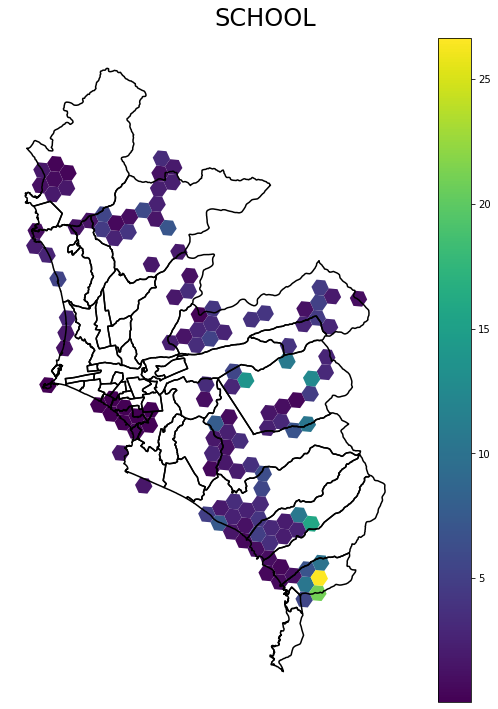

In [495]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

mapaLimaCallao.boundary.plot(ax=ax, color='black', )
# mapaLimaCallao.boundary.plot(ax=ax[1], color='black', )

amenity_minvalues.plot(column='wazeinfo0800_minutes', ax=ax, legend=True)
# amenity_minvalues.plot(column='wazeinfo1400_minutes', ax=ax[1], legend=True)


fig.suptitle(var_amenity.upper(), x=0.6, y=0.98, fontsize = 24)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig(f"img/lima_accessibility_minutes_{var_amenity}.png")

# Plot

<AxesSubplot:>

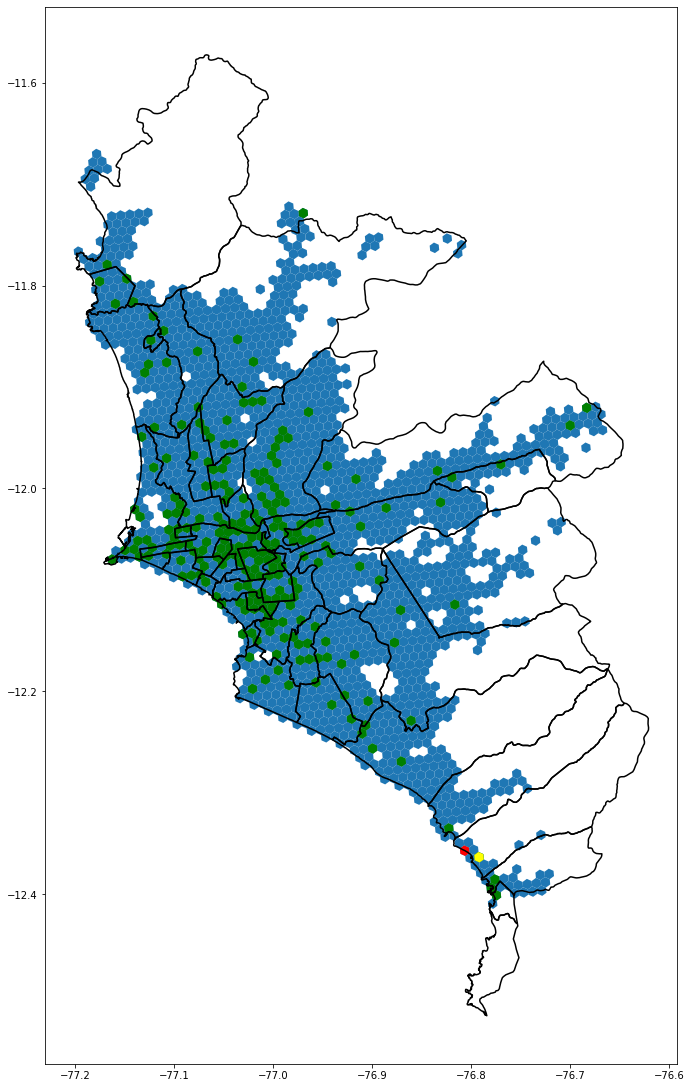

In [307]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,15))

mapaLimaCallao.boundary.plot(ax=ax, color='black', )

lima_nodes_h3.plot(ax=ax)

plot_index = lima_nodes_h3.index.intersection(amenities_h3.index)
amenities_h3.loc[plot_index].plot(ax=ax, color='green')

source = '888e620049fffff'
target = '888e620237fffff'

lima_nodes_h3.loc[[source]].plot(ax=ax, color='red')
amenities_h3.loc[[target]].plot(ax=ax, color='yellow')

# nodes_list = list(['88ef885757fffff', '88ef885751fffff', '88ef885759fffff', '88ef88cdb7fffff', 
#               '88ef88cdb3fffff', '88ef88cdb1fffff', '88ef88cdbdfffff', '88ef88cd87fffff'])

# lima_nodes_h3.loc[nodes_list].plot(ax=ax, color='red')

In [313]:
source_nodes = lima_nodes.query("h3_cell == @source")
source_nodes

,y,x,ref,highway,street_count,geometry,h3_cell,h3_geometry
osmid,,,,,,,,
1273876607,-12.355146,-76.804209,NaN,NaN,3,POINT (-76.80421 -12.35515),888e620049fffff,NaN
1826469755,-12.354101,-76.809342,NaN,NaN,3,POINT (-76.80934 -12.35410),888e620049fffff,NaN
1826469759,-12.354302,-76.808396,NaN,NaN,1,POINT (-76.80840 -12.35430),888e620049fffff,NaN
1826469761,-12.354512,-76.808507,NaN,NaN,4,POINT (-76.80851 -12.35451),888e620049fffff,NaN
1826469763,-12.354591,-76.809597,NaN,NaN,3,POINT (-76.80960 -12.35459),888e620049fffff,NaN
...,...,...,...,...,...,...,...,...
7066595398,-12.353843,-76.806787,NaN,NaN,4,POINT (-76.80679 -12.35384),888e620049fffff,NaN
7066595402,-12.353923,-76.806879,NaN,NaN,3,POINT (-76.80688 -12.35392),888e620049fffff,NaN
7066595403,-12.354032,-76.806966,NaN,NaN,3,POINT (-76.80697 -12.35403),888e620049fffff,NaN


In [314]:
target_nodes = lima_nodes.query("h3_cell == @target")
target_nodes

,y,x,ref,highway,street_count,geometry,h3_cell,h3_geometry
osmid,,,,,,,,
1273504411,-12.367428,-76.792890,NaN,NaN,3,POINT (-76.79289 -12.36743),888e620237fffff,NaN
1273963532,-12.367867,-76.793448,NaN,NaN,4,POINT (-76.79345 -12.36787),888e620237fffff,NaN
1826469870,-12.362509,-76.796372,NaN,NaN,3,POINT (-76.79637 -12.36251),888e620237fffff,NaN
1826469871,-12.362615,-76.796516,NaN,NaN,3,POINT (-76.79652 -12.36262),888e620237fffff,NaN
1826469875,-12.362927,-76.796238,NaN,NaN,3,POINT (-76.79624 -12.36293),888e620237fffff,NaN
...,...,...,...,...,...,...,...,...
7059096571,-12.368599,-76.791469,NaN,NaN,3,POINT (-76.79147 -12.36860),888e620237fffff,NaN
7060566748,-12.364733,-76.794588,NaN,NaN,3,POINT (-76.79459 -12.36473),888e620237fffff,NaN
7060566752,-12.364806,-76.794667,NaN,NaN,3,POINT (-76.79467 -12.36481),888e620237fffff,NaN


In [348]:
%%time
nearest_routes = find_nearest_routes(H, 
                                     source_nodes.index, 
                                     target_nodes.index, 
                                     weight='wazeinfo0800_minutes')  


CPU times: user 517 ms, sys: 3.77 ms, total: 521 ms
Wall time: 520 ms


In [349]:
df = pd.DataFrame.from_dict(nearest_routes, orient='index')

In [350]:
import numpy as np
np.nanmean(df) 

1.317824074074074

# Reading Amenities with Node in Graph

In [539]:
amenitiesGLima = pd.read_csv("data/LimaAmenitiesSnapLimaNodes.csv", sep=';', index_col=[0])
amenitiesGLima['geometry'] = amenitiesGLima['geometry'].apply(wkt.loads)
amenitiesGLima = gpd.GeoDataFrame(amenitiesGLima, crs='epsg:4326')


/home/leibnitz.rojas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7,12,13,22,27,28,35,44,45,48,49,50,52,53,55,56,61,62,63,64,66,67,70,73,77,84,85,86,89,90,96,98,99,100,101,102,103,104,105,109,110,111,113,117,121,122,124,128,133,134,135,149,154,157,167,169,173,175,178,183,185,188,191,193,211,224,225,277,284,286,333,334,335,336,339,341,358,361,370,381,384,391,396,397,398) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [542]:
amenitiesGLima.head()

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry,h3_cell,h3_geometry,glima_osmid,glima_dist
osmid,,,,,,,,,,,,,,,,,,,,,
3259019072,node/3259019072,node,police,POINT (-76.82449200000001 -12.3370718),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.82449 -12.33707),888e620353fffff,POLYGON ((-76.82296089312131 -12.3300052681241...,495244831,0.000330
3759247695,node/3759247695,node,bank,POINT (-76.9060764 -12.2108946),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.90608 -12.21089),888e62c4b7fffff,POLYGON ((-76.90450028009249 -12.2044797168048...,3759247684,0.000133
3759586688,node/3759586688,node,bank,POINT (-76.91030139999999 -12.2310167),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.91030 -12.23102),888e621a57fffff,POLYGON ((-76.90678921709301 -12.2282914892749...,3756733899,0.000346
4235492500,node/4235492500,node,school,POINT (-76.7864862 -12.4911308),NaN,NaN,NaN,NaN,NaN,Entrada A Pucusana,...,NaN,NaN,NaN,NaN,True,POINT (-76.78649 -12.49113),888e620e55fffff,POLYGON ((-76.78939548109929 -12.4838169283747...,1831352656,0.078740
4235507693,node/4235507693,node,school,POINT (-76.796443 -12.4840792),NaN,NaN,NaN,NaN,NaN,Callao,...,NaN,NaN,NaN,NaN,True,POINT (-76.79644 -12.48408),888e620e43fffff,POLYGON ((-76.79473338439676 -12.4764936413050...,1932467999,0.073871


# Find the shortest path from H3 to Amenity

In [558]:
amenitiesGLima['amenity'].unique()

array(['police', 'bank', 'school', 'courthouse', 'university', 'hospital'],
      dtype=object)

In [612]:
var_amenity = 'bank'

logger.info(f"Starting process for amenity {var_amenity} ")

cols = [var_amenity]
amenities = amenitiesGLima.query("amenity in @cols")
amenities.shape

2024-02-28 23:06:45,927 :: INFO :: root :: 29410 :: Starting process for amenity bank 


(1110, 405)

In [613]:
nearestnodes2amenities = list(amenities['glima_osmid'].unique())
len(nearestnodes2amenities)

839

In [614]:
nodes_source = list(limanodesh3_snap_limanodes['glima_osmid'].unique())
print(len(nodes_source))
nodes_target = nearestnodes2amenities
print(len(nodes_target))

1770
839


In [615]:
def shortest_path_transporte(graph, node_source, node_target):
    try:
        resdict = {}
        for w in ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']:
            res = nx.shortest_path_length(graph, 
                                      source=node_source, 
                                      target=node_target, 
                                      weight=w)
            resdict[w] = res
    except Exception as e:
        resdict = {}
    return resdict  

In [616]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))
len(nodes_sourcecrosstarget)

1485030

In [617]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,1826469795,3759247684
1,1826469795,3756733899
2,1826469795,4351359770


In [618]:
nodes_sourcecrosstarget_df.shape[0] , nodes_sourcecrosstarget_df.shape[0]/40

(1485030, 37125.75)

In [619]:
%%time
def process_row(row):
    result = shortest_path_transporte(H, row.source, row.target)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 30000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 40


2024-02-28 23:07:37,535 :: INFO :: root :: 29410 :: Multiprocessing started.
2024-02-28 23:45:48,871 :: INFO :: root :: 29410 :: Multiprocessing completed.


CPU times: user 5.01 s, sys: 6.22 s, total: 11.2 s
Wall time: 38min 15s


In [620]:
%%time
results_df = pd.DataFrame(pd.concat(results), columns=['dict'])
results_df.head()

cond = results_df['dict'].map(len)>0
results_df[cond]

df = nodes_sourcecrosstarget_df.merge(results_df[cond], how='inner', left_index=True, right_index=True)
df.head()

# Create an empty DataFrame with columns as unique keys from all dictionaries
columns = set().union(*(d.keys() for d in df['dict'] if d))
df2 = pd.DataFrame(columns=columns)
df2.head()

# Iterate through each row's dictionary and populate the result DataFrame
for idx, row in df.iterrows():
    df2.loc[idx] = row['dict']

# df.merge(df2, )
df3 = df[['source', 'target']].merge(df2, how='left', left_index=True, right_index=True)
df3

#Archivo final de datos con resolution para H3
df3.to_csv(f"data/limaprivado_wazeresults_h3res8_{var_amenity}.csv", sep=';', index=False)

logger.info(f"Finishing process for amenity {var_amenity} ")

2024-02-28 23:47:23,614 :: INFO :: root :: 29410 :: Finishing process for amenity bank 


CPU times: user 1min 33s, sys: 355 ms, total: 1min 34s
Wall time: 1min 34s


In [635]:
# var_amenity = 'courthouse'
amenity_wazevalues = pd.read_csv(f"data/limaprivado_wazeresults_h3res8_{var_amenity}.csv", sep=';')
# amenity_wazevalues
cols = ['wazeinfo0800_km', 'wazeinfo1400_km', 'wazeinfo0800_minutes', 'wazeinfo1400_minutes']
amenity_minvalues = amenity_wazevalues.groupby('source')[cols].min()
amenity_minvalues

,wazeinfo0800_km,wazeinfo1400_km,wazeinfo0800_minutes,wazeinfo1400_minutes
source,,,,
108013939,0.033,0.033,0.000000,0.000000
108041437,0.053,0.053,0.000000,0.000000
114612795,0.032,0.032,0.050000,0.050000
114615167,0.075,0.075,0.000000,0.000000
133928358,0.035,0.035,0.000000,0.000000
...,...,...,...,...
11058034406,2.636,2.636,6.383333,6.766667
11059024321,2.596,2.596,4.433333,5.083333
11070563374,3.033,3.033,10.133333,9.183333


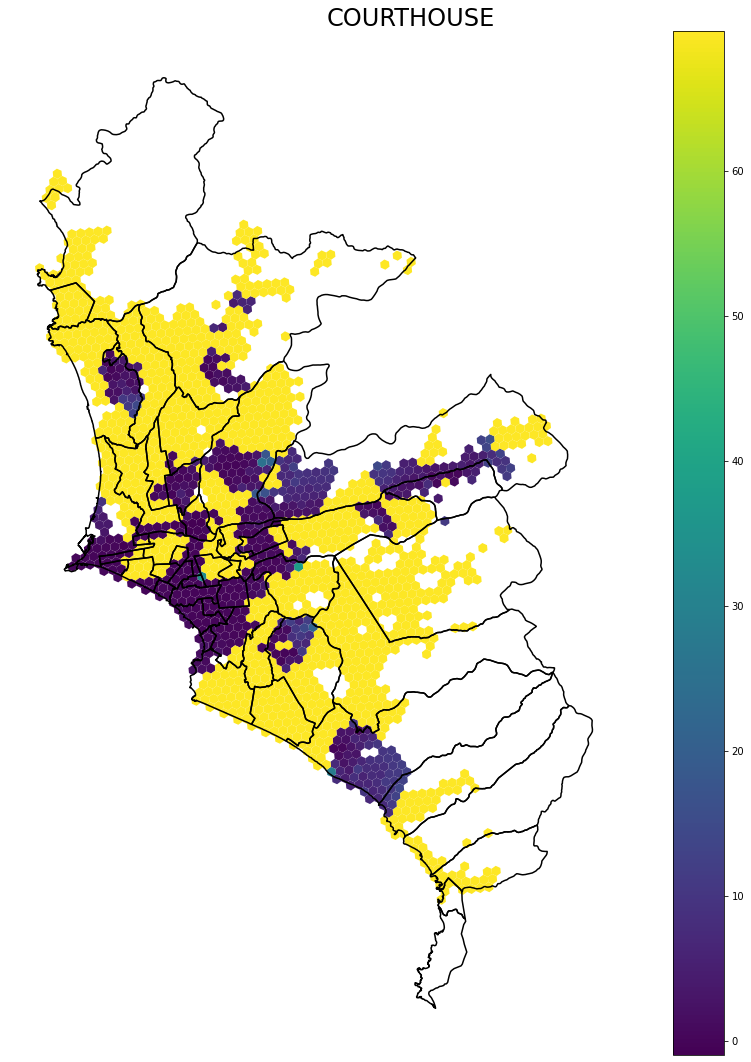

In [636]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

mapaLimaCallao.boundary.plot(ax=ax, color='black', )
# mapaLimaCallao.boundary.plot(ax=ax[1], color='black', )

gdf2plot = limanodesh3_snap_limanodes.reset_index().merge(amenity_minvalues.reset_index(), 
                                            how='left', 
                                            left_on='glima_osmid', 
                                            right_on='source'
                                           )

gdf2plot = gpd.GeoDataFrame(gdf2plot, crs='epsg:4326')

column4color = 'wazeinfo0800_minutes'
maxvalue = gdf2plot[column4color].max()
gdf2plotfillna = gdf2plot.fillna({column4color:maxvalue})
gdf2plotfillna.set_geometry('h3_geometry').plot(column=column4color, ax=ax, legend=True)


fig.suptitle(var_amenity.upper(), x=0.6, y=0.98, fontsize = 24)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig(f"img/lima_accessibility_minutes_{var_amenity}.png")

In [637]:
gdf2plotfillna.to_csv(f"data/data4map_{var_amenity}.csv", sep=";", index=False)
# gdf2plotfillna

In [638]:
!ls data

data4map_bank.csv
data4map_courthouse.csv
data4map_police.csv
GrafoLima_edges.csv
GrafoLima_edgeswaze.csv
GrafoLima_edgeswaze.zip
GrafoLima_nodes.csv
GrafoLima_nodes.zip
GrafoSanBorja_edges.csv
GrafoSanBorja_nodes.csv
Lima_6Amenities.csv
LimaAmenitiesSnapLimaNodes0.csv
LimaAmenitiesSnapLimaNodes.csv
LimaH3R8SnapLimaNodes.csv
LimaH3SnapLimaNodes.csv
LimaMinValues2Amenities.csv
limaprivado_wazeresults_h3res7_bank.csv
limaprivado_wazeresults_h3res7_police.csv
limaprivado_wazeresults_h3res7_school.csv
limaprivado_wazeresults_h3res8_bank.csv
limaprivado_wazeresults_h3res8_courthouse.csv
limaprivado_wazeresults_h3res8_police.csv
limaprivado_wazeresults_police.csv
limaprivado_wazeresults_university.csv
wazeresults30kmh_bank.csv
wazeresults30kmh_courthouse.csv
wazeresults30kmh_hospital.csv
wazeresults30kmh_police.csv
wazeresults30kmh_school.csv
wazeresults30kmh_university.csv
wazeresults_bank.csv
wazeresults_courthouse.csv
wazeresults_hospital.csv
wazeresults_police.csv
wazeresults_school.csv
